In [1]:
# Bibliotecas utilizadas para calcular as estatísticas e plotar os gráficos
import seaborn as sns
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
from biokit.viz import corrplot
from scipy import stats
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import math

In [2]:
# lê o arquivo csv
dados = pd.read_csv("treinamentoAIBA_2016_dryRainy_noClass.csv", sep = ',')

In [3]:
standardiseddata = scale(dados)
standardiseddata = pd.DataFrame(standardiseddata, index=dados.index, columns=dados.columns)

In [4]:
stdzmean = standardiseddata.apply(np.mean)
stdzdev = standardiseddata.apply(np.std)

In [5]:
corr = dados.corr()

/usr/lib/python3.6/site-packages/biokit/viz/linkage.py:41: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = hierarchy.linkage(D, method=method, metric=metric)


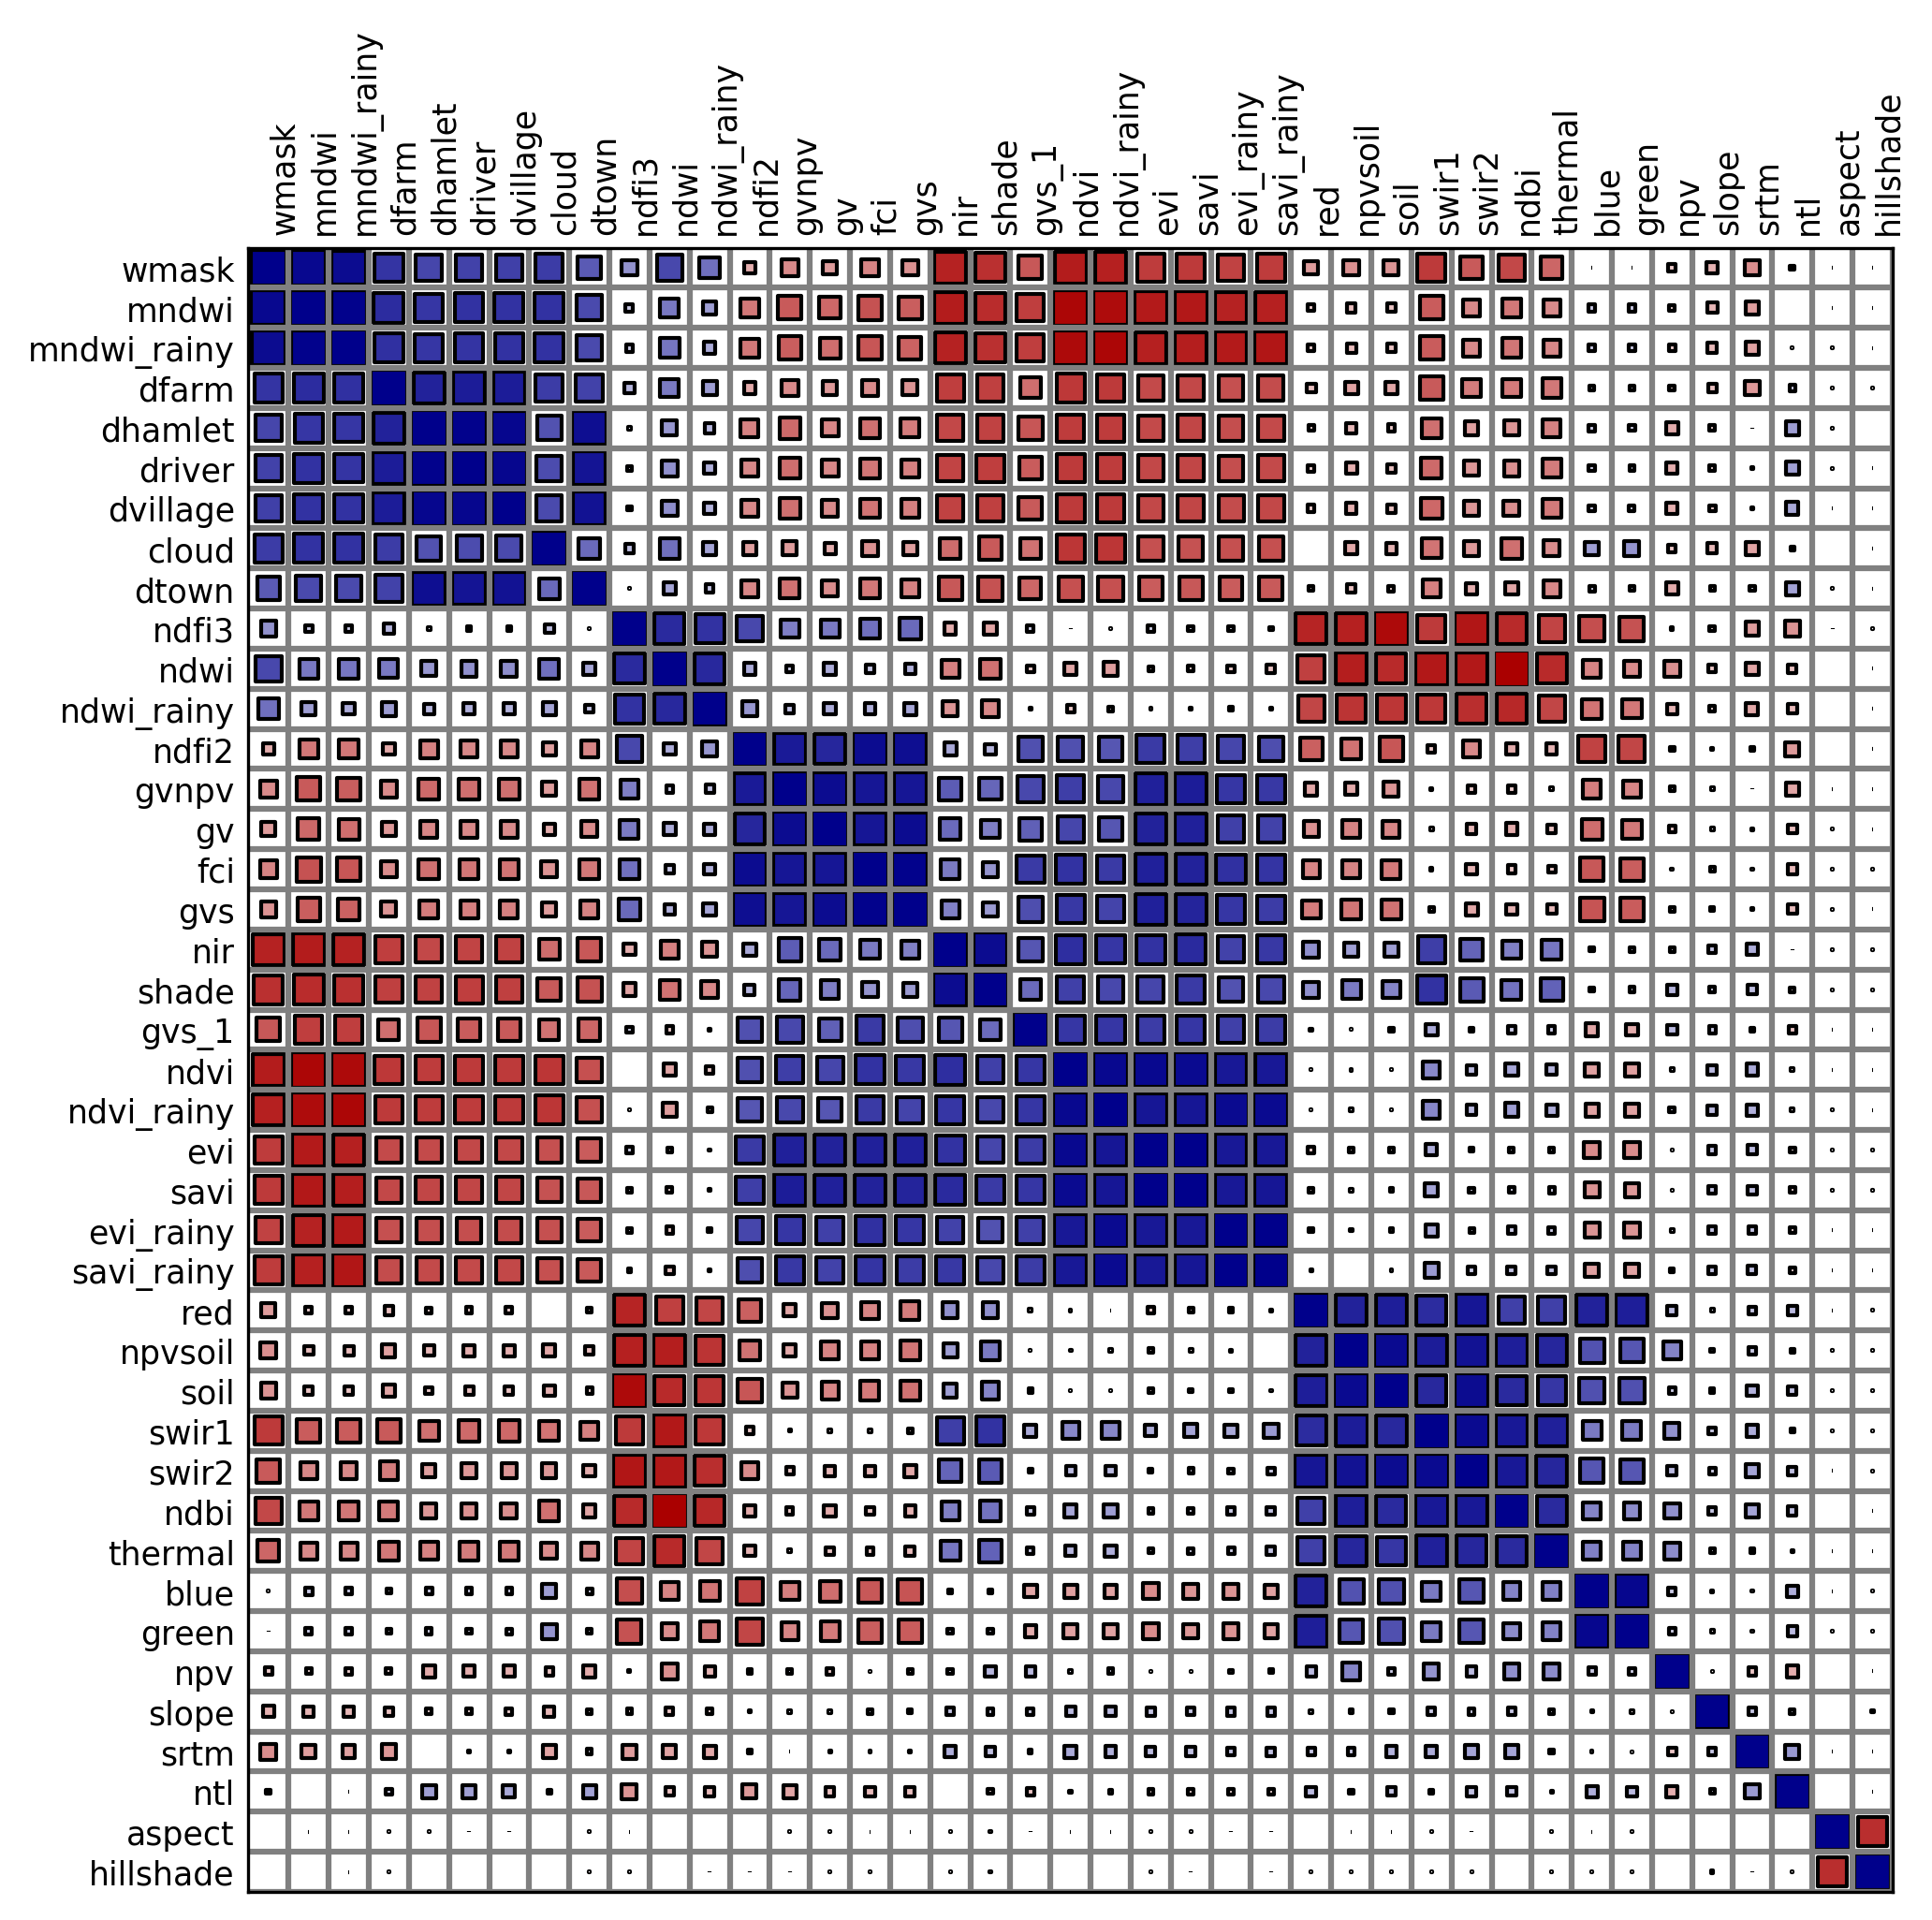

In [6]:
f, ax = plt.subplots(figsize=(9, 7), dpi = 300)
c = corrplot.Corrplot(corr)
c.plot(fig = f, colorbar=False, method='square', shrink=.9, rotation=90)

In [7]:
f.savefig('biokitSquareAIBA.png')

In [8]:
# Função para gerar as estatísticas dentro do pairGrid
def setStatCoeff(x, y, **kws):
    dat = pd.concat([x, y], axis=1)
    model = smf.ols(dat.columns[0] + ' ~ ' + dat.columns[1], data=dat).fit()
    
    ax = plt.gca()
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(dat.columns[0] + '-' + dat.columns[1])
    
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
    ax.annotate('n = %4i' %model.nobs, xy = (.05, .8), xycoords=ax.transAxes)
    #ax.annotate('r = %6.4f' %math.sqrt(model.rsquared), xy = (.05, .7), xycoords=ax.transAxes)
    ax.annotate('r² = %6.4f' %model.rsquared, xy = (.05, .6), xycoords=ax.transAxes)
    ax.annotate('r²-adjusted = %6.4f' %model.rsquared_adj, xy = (.05, .5), xycoords=ax.transAxes)
    ax.annotate('f-stat = {:.2e}'.format(model.f_pvalue), xy = (.05, .4), xycoords=ax.transAxes)
    ax.annotate('y = %5.2f + (%6.3f) %s' %(model.params['Intercept'], model.params[dat.columns[1]], dat.columns[1]), xy = (.05, .3), xycoords=ax.transAxes)
    

In [9]:
aa = dados.loc[:,['savi','savi_rainy','evi','evi_rainy', 'srtm']]

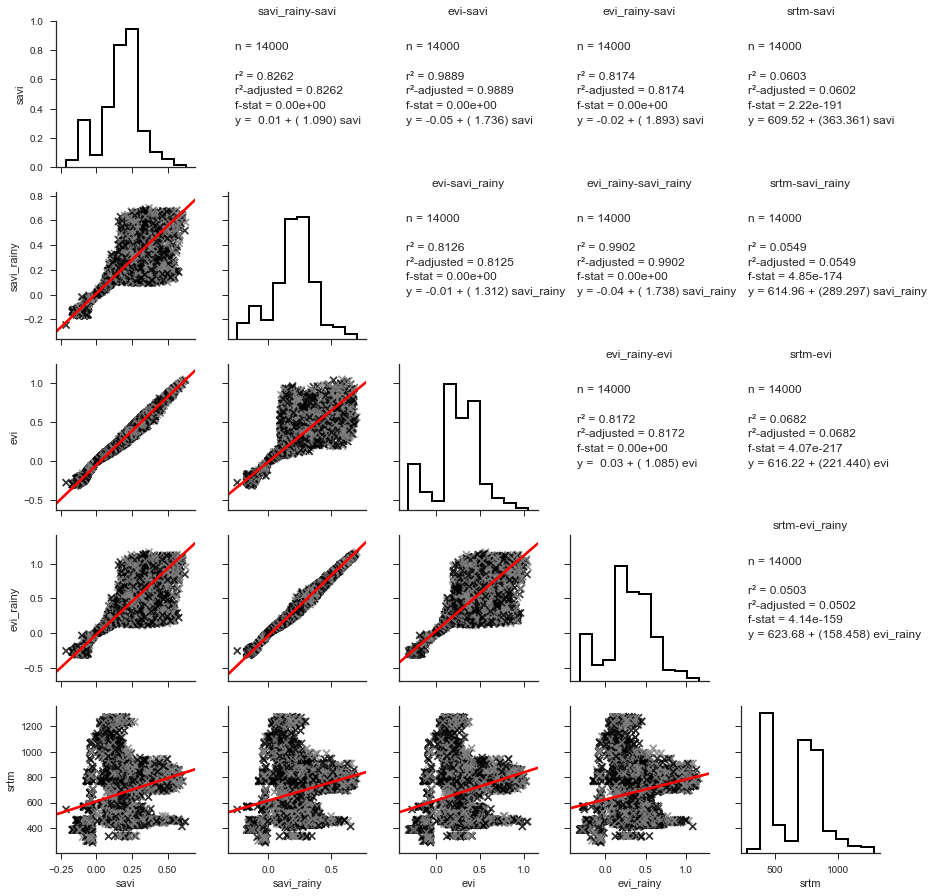

In [10]:
# Define o tipo de gráfico e o que plotar
sns.set(style = 'ticks') # ticks, whitegrid, dark, white

g = sns.PairGrid(aa)
g.map_upper(setStatCoeff)
g.map_diag(plt.hist, color = 'black', histtype="step", linewidth = 2)
g.map_lower(sns.regplot, marker='x',scatter_kws={'color': ['black','grey']}, line_kws={'color': 'red'})

In [11]:
g.savefig('pairPlotCorrelacaoAIBA.png', dpi = 96)

In [12]:
#PCA

pca = PCA().fit(standardiseddata)

In [13]:
def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(list(zip(a, b, c)), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

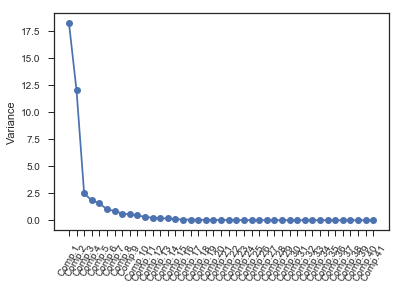

In [14]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, standardiseddata)

In [15]:
def calcpc(variables, loadings):
    # find the number of samples in the data set and the number of variables
    numsamples, numvariables = variables.shape
    # make a vector to store the component
    pc = np.zeros(numsamples)
    # calculate the value of the component for each sample
    for i in range(numsamples):
        valuei = 0
        for j in range(numvariables):
            valueij = variables.iloc[i, j]
            loadingj = loadings[j]
            valuei = valuei + (valueij * loadingj)
        pc[i] = valuei
    return pc

In [16]:
calcpc(standardiseddata, pca.components_[0])

array([-2.64641729, -2.22370749, -2.27902646, ...,  0.89368524,
        1.52305741,  3.00143552])

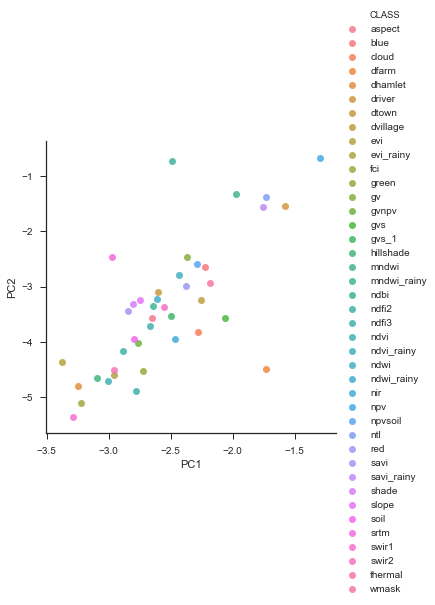

In [17]:
def pca_scatter(pca, standardised_values, classifs):
    foo = pca.transform(standardised_values)
    bar = pd.DataFrame(list(zip(foo[:, 0], foo[:, 1], classifs)), columns=["PC1", "PC2", "CLASS"])
    sns.lmplot("PC1", "PC2", bar, hue="CLASS", fit_reg=False)

pca_scatter(pca, standardiseddata, dados.columns)

In [18]:
loadings = pd.DataFrame(pca.components_.T)
loadings.index = ['PC %s' % pc for pc in loadings.index + 1]
loadings.columns = ['TS %s' % pc for pc in loadings.columns + 1]

In [19]:
def z_score(x):
    """Remove a média e normaliza os dados pelo desvio padrão"""
    return (x - x.mean()) / x.std()

In [20]:
pca = PCA(n_components=None)
pca.fit(dados.apply(z_score).T)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [21]:
loadings = pd.DataFrame(pca.components_.T)
loadings.index = ['PC %s' % pc for pc in loadings.index + 1]
loadings.columns = ['TS %s' % pc for pc in loadings.columns + 1]

In [22]:
PCs = np.dot(loadings.values.T, dados)

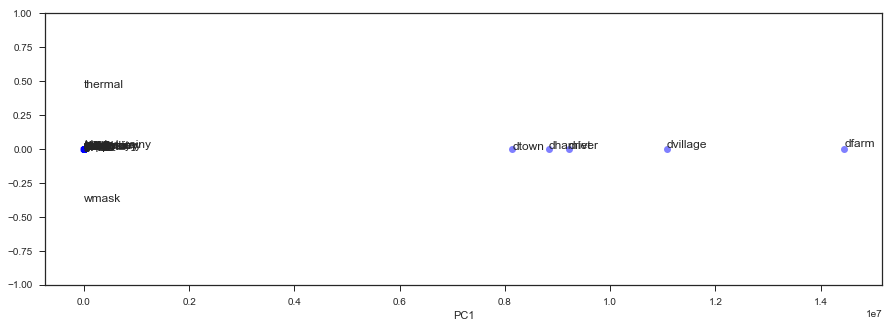

In [23]:
marker = dict(linestyle='none', marker='o', markersize=7, color='blue', alpha=0.5)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(PCs[0], np.zeros_like(PCs[0]),
        label="Scores", **marker)
[ax.text(x, y, t) for x, y, t in zip(PCs[0], loadings.values[1, :], dados.columns)]

ax.set_xlabel("PC1")

_ = ax.set_ylim(-1, 1)
marker = dict(linestyle='none', marker='o', markersize=7, color='blue', alpha=0.5)

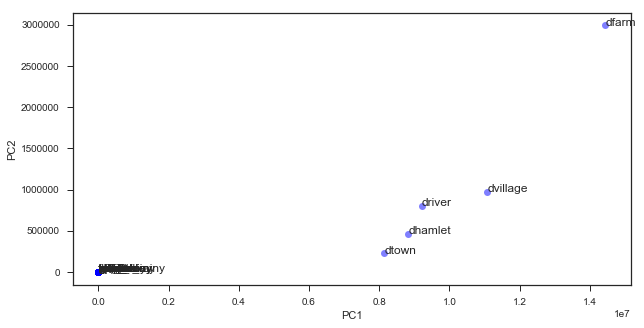

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(PCs[0], PCs[1], label="Scores", **marker)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

text = [ax.text(x, y, t) for x, y, t in
        zip(PCs[0], PCs[1]+0.5, dados.columns)]

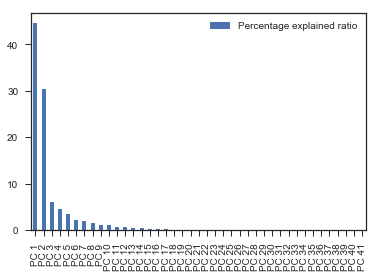

In [25]:
perc = pca.explained_variance_ratio_ * 100
perc = pd.DataFrame(perc, columns=['Percentage explained ratio'], index=['PC %s' % pc for pc in np.arange(len(perc)) + 1])

ax = perc.plot(kind='bar')

In [26]:
pca.explained_variance_ratio_

array([  4.46312155e-01,   3.03651828e-01,   6.12958000e-02,
         4.60183800e-02,   3.38911565e-02,   2.22518071e-02,
         1.92671609e-02,   1.44371353e-02,   1.15189971e-02,
         1.08396342e-02,   7.52798557e-03,   5.62295249e-03,
         4.20405009e-03,   3.64383009e-03,   2.35058816e-03,
         1.53110905e-03,   1.20126884e-03,   9.55172642e-04,
         7.38052103e-04,   6.63913576e-04,   5.62859302e-04,
         4.51224067e-04,   2.69788579e-04,   2.22230829e-04,
         1.71296665e-04,   1.29452427e-04,   6.32711255e-05,
         5.29619091e-05,   4.31304363e-05,   3.62184343e-05,
         2.95477122e-05,   2.08409453e-05,   1.49497756e-05,
         6.74371341e-06,   2.05143558e-06,   4.09572649e-07,
         4.52268410e-08,   1.09935650e-09,   1.86516068e-18,
         2.51453166e-31,   8.80195526e-32])

In [27]:
pca.explained_variance_ratio_.cumsum()

array([ 0.44631215,  0.74996398,  0.81125978,  0.85727816,  0.89116932,
        0.91342113,  0.93268829,  0.94712542,  0.95864442,  0.96948405,
        0.97701204,  0.98263499,  0.98683904,  0.99048287,  0.99283346,
        0.99436457,  0.99556584,  0.99652101,  0.99725906,  0.99792298,
        0.99848584,  0.99893706,  0.99920685,  0.99942908,  0.99960038,
        0.99972983,  0.9997931 ,  0.99984606,  0.99988919,  0.99992541,
        0.99995496,  0.9999758 ,  0.99999075,  0.99999749,  0.99999954,
        0.99999995,  1.        ,  1.        ,  1.        ,  1.        ,  1.        ])